В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, roc_curve, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Считываем данные

In [ ]:
X = pd.read_csv('weather.csv')

## Вспомогательные функции

Функция визуализации результатов

In [ ]:
def result(X_test, y_test, y_train, y_pred_test, y_pred_train):
  print(f'Train MSE = {mean_squared_error(y_train, y_pred_train)}')
  print(f'Test MSE = {mean_squared_error(y_test, y_pred_test)}')
  print('_'*60)
  print(classification_report(y_test, y_pred_test))

Функция подбора параметров

In [ ]:
def choose_param(param_grid, clf):
  # формируем пайп
  pipeline = Pipeline(steps=[
    ('scal', RobustScaler()),
    ('clf', clf)
  ])
  # ищем лучший коэффициент
  search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
  search.fit(X_train, y_train)
  print("Best parameter (CV score=%0.3f):" % search.best_score_)
  print(search.best_params_)

Функция визуализации ROC кривой

In [ ]:
def ROC_visualization(fpr, tpr, thresholds): 
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression')
  plt.plot([0, 1], [0, 1],'b--')
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()

## Работа с признаками

Отделяем признаки от меток

In [ ]:
y = X.RainTomorrow.replace({'No':-1, 'Yes': 1})

Проверяем корреляциию признаков с метками

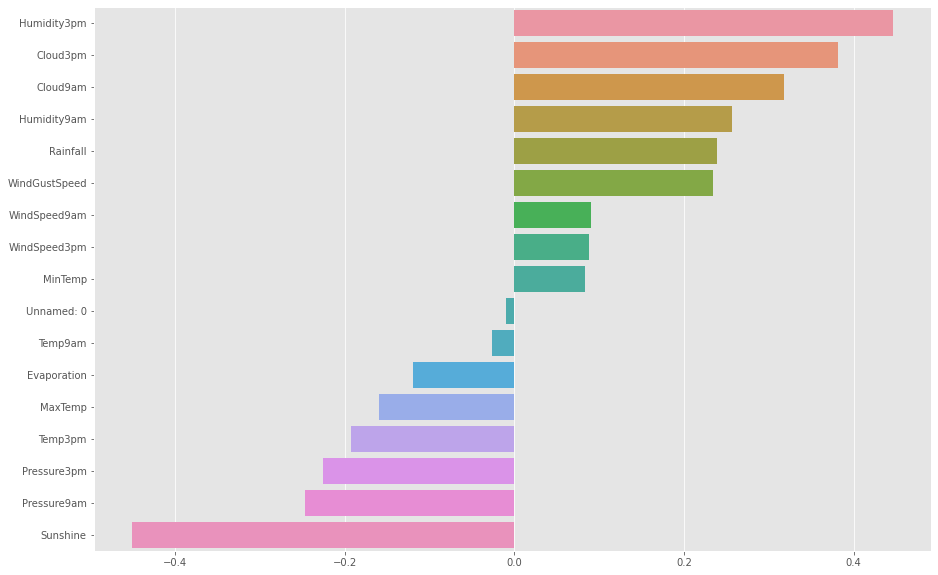

In [ ]:
correlations = X.corrwith(y).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Выбрасываем признаки и все, что слабо коррелирует с ними (вряд ли сильно повлияет на результат, зато выиграем во времени)

In [ ]:
del X['RainTomorrow'], X['Unnamed: 0'], X['Temp9am']

Больше половины значений каждого признака *non-null*, значит рассматривать будем все

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

Переводим дату к формату *int*

In [ ]:
X.Date = pd.to_datetime(X.Date).astype(np.int64)

Убираем *NaN* в категориальных признаках, а в числовых признаках меняем на среднее значение

In [ ]:
categorical = X.select_dtypes([np.object_]).columns
numerical = X.select_dtypes([np.number]).columns
X[numerical] = X[numerical].fillna(X.select_dtypes([np.number]).mean())
X[categorical] = X[categorical].fillna("NotGiven")

OneHotEncoding на категориальные признаки

In [ ]:
X = pd.get_dummies(X)

Разделим данные на train/test в отношении $ 75:25 $

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=0,
                                                    shuffle=False)

## Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

Ищем лучший параметр для лог. регрессии

In [ ]:
param_grid = {'clf__C': np.logspace(-3, 3, 4) }
choose_param(param_grid, LogisticRegression())

Best parameter (CV score=0.834):
{'clf__C': 0.001}


Пайп с лучшим параметром лог. регрессии

In [ ]:
pipeline = Pipeline(steps=[
    ('scal', RobustScaler()),
    ('clf', LogisticRegression(C = 0.001))
])

Результаты работы

In [ ]:
startTime = time.time()

model = pipeline.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

endTime = time.time()
totalTime = endTime - startTime

y_pred_train = model.predict(X_train)
result(X_test, y_test, y_train, y_pred_test, y_pred_train)
print(f'Time for fit and predict = {totalTime}')

Train MSE = 0.6210944825775477
Test MSE = 0.594897184168331
____________________________________________________________
              precision    recall  f1-score   support

          -1       0.87      0.95      0.91     27882
           1       0.74      0.47      0.58      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.71      0.74     35549
weighted avg       0.84      0.85      0.84     35549

Time for fit and predict = 6.734589338302612


ROC кривая

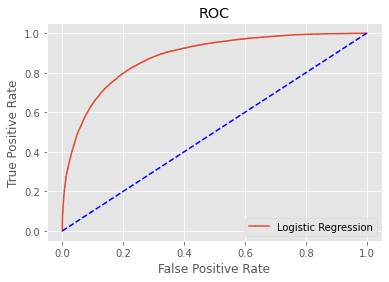

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
ROC_visualization(fpr, tpr, thresholds)

## Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Ищем лучший параметр для ближайших соседей

In [ ]:
param_grid = {'clf__n_neighbors': [1, 2, 5, 10]}
choose_param(param_grid, KNeighborsClassifier())

Best parameter (CV score=0.819):
{'clf__n_neighbors': 10}


Пайп с лучшими параметрами ближайших соседей

In [ ]:
pipeline = Pipeline(steps=[
    ('scal', RobustScaler()),
    ('clf', KNeighborsClassifier(n_neighbors = 10))
])

Результат работы

In [ ]:
startTime = time.time()

model = pipeline.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

endTime = time.time()
totalTime = endTime - startTime

y_pred_train = model.predict(X_train)
result(X_test, y_test, y_train, y_pred_test, y_pred_train)
print(f'Time for fit and predict = {totalTime}')

Train MSE = 0.5896252953752672
Test MSE = 0.6853638639624181
____________________________________________________________
              precision    recall  f1-score   support

          -1       0.84      0.96      0.90     27882
           1       0.72      0.34      0.46      7667

    accuracy                           0.83     35549
   macro avg       0.78      0.65      0.68     35549
weighted avg       0.81      0.83      0.80     35549

Time for fit and predict = 94.48717737197876


ROC кривая

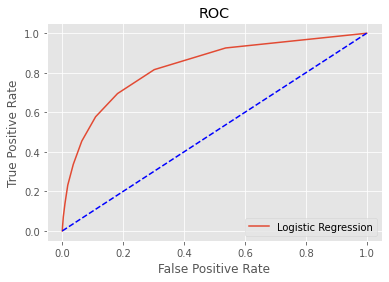

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
ROC_visualization(fpr, tpr, thresholds)

## Байесовский классификатор

In [ ]:
from sklearn.naive_bayes import BernoulliNB 

Ищем лучший параметр для байесовского классификатора

In [ ]:
param_grid = {'clf__alpha': [1, 2, 3, 0]}
choose_param(param_grid, BernoulliNB())

Best parameter (CV score=0.728):
{'clf__alpha': 3}


Пайп с лучшими параметрами байесовского классификатора

In [ ]:
pipeline = Pipeline(steps=[
    ('scal', StandardScaler()),
    ('clf', BernoulliNB(alpha = 3))
])

Результат работы

In [ ]:
startTime = time.time()

model = pipeline.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

endTime = time.time()
totalTime = endTime - startTime

y_pred_train = model.predict(X_train)
result(X_test, y_test, y_train, y_pred_test, y_pred_train)
print(f'Time for fit and predict = {totalTime}')

Train MSE = 0.8979783203930836
Test MSE = 0.8622464766941405
____________________________________________________________
              precision    recall  f1-score   support

          -1       0.90      0.81      0.86     27882
           1       0.50      0.69      0.58      7667

    accuracy                           0.78     35549
   macro avg       0.70      0.75      0.72     35549
weighted avg       0.82      0.78      0.80     35549

Time for fit and predict = 0.9109141826629639


ROC кривая

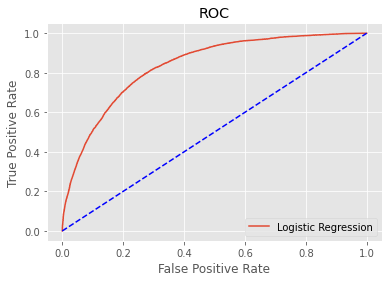

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
ROC_visualization(fpr, tpr, thresholds)

## Самостоятельно (ну почти) реализованная логистическая регрессия

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, -1, -1])

In [ ]:
def probability(theta, X):
    result = 1 / (1 + np.exp(-np.dot(X, theta)))
    
    return result
    
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{-1, 1\}$

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    seq = map(int, prob > threshold)
    result = np.fromiter(seq, dtype=np.int)
    result[result == 0] = -1

    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == -1, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell} \log \left(1 + \exp(-y_i \langle \theta, x_i \rangle)\right) \to \operatorname*{min}_{\theta}$

Реализуем его в функции logloss:

In [ ]:
def logloss(theta, X, y): 
    result = np.sum(np.log(1 + np.exp(-y*np.dot(X, theta))))/np.shape(X)[0]
    return result

In [ ]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся

Реализуем функцию рассчета градиента функционала качества

$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}\log \left(1 + \exp(- y_i \langle \theta, x_i \rangle)\right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}\frac {1}{1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle)\cdot -y_i x_{ij}$

Реализуйте рассчет градиента в матричном виде:

In [ ]:
def gradient(theta, X, y):
    # YOUR CODE HERE
    result = np.exp(-y*np.dot(X, theta)) * -(np.dot(X.T, y[:, np.newaxis])) / (1 + np.exp(-y * np.dot(X, theta)))/np.shape(X)[0]
    return result[:,0]

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [ ]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

### Построение

Подсчет оптимальных параметров и вывод результата

Train MSE = 0.6390983083905329
Test MSE = 1.4389153000084391
____________________________________________________________
              precision    recall  f1-score   support

          -1       0.91      0.60      0.72     27882
           1       0.35      0.79      0.49      7667

    accuracy                           0.64     35549
   macro avg       0.63      0.69      0.60     35549
weighted avg       0.79      0.64      0.67     35549

Time for fit and predict = 120.07051610946655


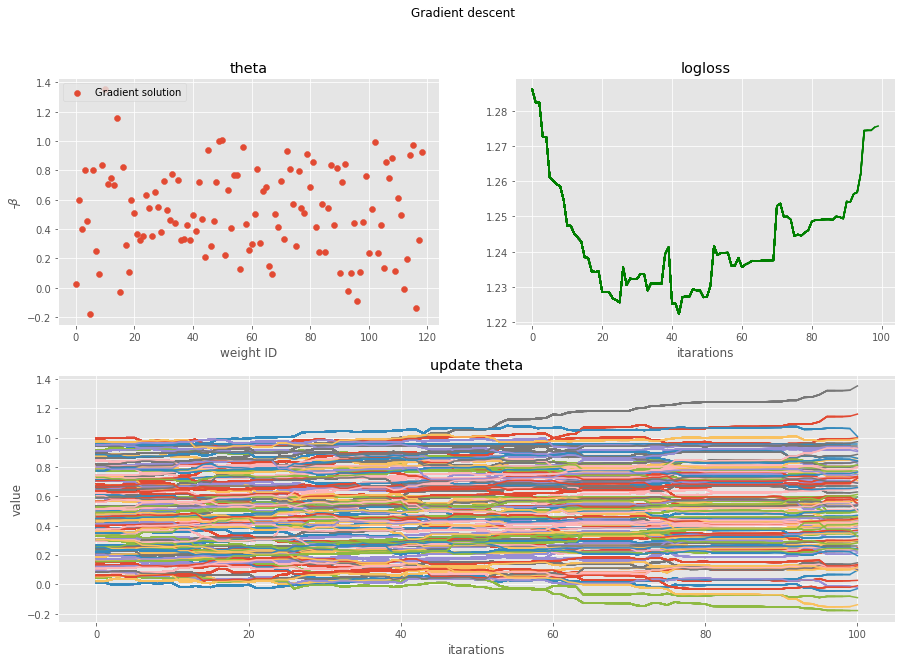

In [ ]:
startTime = time.time()

optimal_theta = fit(StandardScaler().fit_transform(X_train), y_train.to_numpy())
y_pred_test = binary_class_prediction(optimal_theta, StandardScaler().fit_transform(X_test))

endTime = time.time()
totalTime = endTime - startTime

y_pred_train = model.predict(X_train)
result(X_test, y_test, y_train, y_pred_test, y_pred_train)
print(f'Time for fit and predict = {totalTime}')

### Вывод

По результатам проделаной работы можно сделать вывод, что самую лучшую точность дает метод логистической регрессии *sklearn.linear_model.LogisticRegression*.  

Наименьшее время работы получается у метода Байесовского классификатора *sklearn.naive_bayes.BernoulliNB* (берем распределение Бернули, так как у нас бинарные значения меток), но он проигрывает в точности остальным встроенным методам. 

Метод k ближайших соседей *sklearn.neighbors.KNeighborsClassifier* (по отношению к другим предложенным методам) работает сильно медленно, но не дает значительного выигрыша в точности (возможно, при более качественной настройке параметров, данный метод даст более точный результат, но прогонять всевозможные варианты очень долго). Долгое время работы связано с тем, что в больших наборах данных (а после OneHotEncoding их стало в разы больше) стоимость вычисления расстояния между новой точкой и каждой существующей точкой очень высокая.

Самостоятельно реализованная версия логистической регресии проигрывает и в точности предсказания и во времени работы (варьирование параметров не дало каких-то значимых результатов)